In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path|
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

In [2]:
class setup:
    dummy = 0

def t_coeff(n):
    '''
    Returns t-test coefficient
    n -- number of points
    '''
    assert n > 0, 'n must be positive'
    __students = [12.7062, 4.3027, 3.1824, 2.7764, 2.5706, 2.4469, 2.3646, 2.3060, 2.2622]
    if n < len(__students):
        return __students[n-1]
    else:
        return 2

In [3]:
class Spectrum:
    def __init__(self, data):
        self.wavelen = data["Wavelength"]
        self.intensity = data["Intensity"]

class SpectrumFile:
    def __init__(self, file, noise):
        spectrum_data = pd.read_csv( file, skiprows=13, delimiter='\t', names=["Wavelength", "Intensity"],
                                     dtype=np.float64, decimal=',')
        noise_data = pd.read_csv( noise, skiprows=13, delimiter='\t', names=["Wavelength", "Intensity"],
                                  dtype=np.float64, decimal=',')
        
        self.noise = Spectrum( noise_data)
        self.spectrum = Spectrum( spectrum_data)
        
        norm = self.spectrum.intensity.max()
        self.spectrum.intensity = self.spectrum.intensity / norm
        self.noise.intensity = self.noise.intensity / norm
        

spectra = { 
    "air" : SpectrumFile( "data/air_spectrum.txt", "data/air_noise.txt"),
    "water" : SpectrumFile( "data/water_spectrum.txt", "data/water_noise.txt"),
    "lamp_sharovaya" : SpectrumFile( "data/lamp_sharovaya_spectrum.txt", "data/lamp_sharovaya_noise.txt"),
    "lamp_tube" : SpectrumFile( "data/lamp_tube_spectrum.txt", "data/lamp_tube_noise.txt"),
    "lamp_ar" : SpectrumFile( "data/lamp_ar_spectrum.txt", "data/lamp_ar_noise.txt"),
    "tirat_xe" : SpectrumFile( "data/tirat_xe_spectrum.txt", "data/tirat_xe_noise.txt"),
}

In [4]:
import itertools

def spectrum_lines( file, n_lines = 40):
    lines_df = pd.read_csv( file, delimiter=',', dtype=np.float64, decimal='.')
    
    lines = {}
    for elem in lines_df.columns[1:]:        
        elem_lines = lines_df.get( ['Wavelength', elem]).dropna()
        elem_lines = elem_lines.sort_values( by = [elem])[-n_lines:]
        lines[elem] = np.sort( elem_lines['Wavelength'].to_numpy())

    return lines


COLORS = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
def show_spectrum_lines( elem_lines, label, waverange, color = None, plot = plt):
    low_index, high_index = get_safe_range( elem_lines, waverange)
    plot.vlines( elem_lines[low_index:high_index], 0, 1, colors=color, linestyles='solid', label=label, linewidth = 0.5)

def show_all_spectrum_lines( lines, waverange, plot = plt ):
    color = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
    for key in lines:
        show_spectrum_lines( lines[key], key, waverange, color = next(COLORS), plot = plot)

def show_named_spectrum_lines( lines, names, waverange, plot = plt ):
    color = itertools.cycle(['green', 'blue', 'orange', 'red', 'yellow'])
    for key in names:
        show_spectrum_lines( lines[key], key, waverange, color = next(COLORS), plot = plot)        
        

In [5]:
def get_safe_range( data, safe_range):
    if data.min() > safe_range[1] or data.max() < safe_range[0]:
        print('AHTUNG!')
        return 0, 0;
    
    low_index  = np.argmax( data >= safe_range[0])
    high_index = np.argmax( data >= safe_range[1])
    
    if high_index == 0:
        high_index = len(data)
    print(low_index)
    print(high_index)
    return low_index, high_index

In [6]:
def show_blackbody(T, safe_range, scale, plot):
    c = 2.99e8
    h = 6.62e-34
    k = 1.38e-23    
    
    x = np.linspace( safe_range[0], safe_range[1], 1000)
    y = 1 / ( ((x)*1e-9)**5 * ( np.exp((h*c) / (T*k*(x)*1e-9)) - 1 ) ) 
    y = scale * y / y.max()
    
    plot.plot( x, y, ls=':', label='black body T={}K'.format(T), c='r')
    



## Spectra

In [7]:
from scipy.interpolate import splrep, BSpline

def show_spectrum( spec, s, waverange, plot = plt):


    assert spec.spectrum.wavelen.size == spec.noise.wavelen.size
    
    low_index, high_index = get_safe_range( spec.spectrum.wavelen, waverange)

    spectrum_x = spec.spectrum.wavelen[low_index:high_index]
    spectrum_y = spec.spectrum.intensity[low_index:high_index]
    noise_x    = spec.noise.wavelen[low_index:high_index]
    noise_y    = spec.noise.intensity[low_index:high_index]
    
    norm = spectrum_y.max()
    spectrum_y = spectrum_y / norm
    noise_y = noise_y / norm
    
    plot.scatter( spectrum_x, spectrum_y, color='purple', s=0.1)
    plot.scatter( noise_x, noise_y, color='blue', s=0.1, label='noise')

    tck = splrep( spectrum_x, spectrum_y, s=s)
    plot.plot( spectrum_x,  BSpline(*tck)( spectrum_x), linewidth=1, color='black', label='spectrum', zorder=10)
    plot.legend()
    
    
    
    

### Air spectrum

164
1976
0
32
0
27
16
40


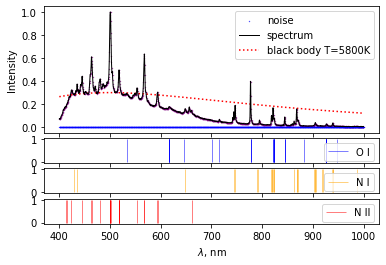

In [128]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['air'], 0, (400, 1000), plot = ax1) 

no_lines = spectrum_lines("data/no_lines.txt")
#show_all_spectrum_lines( no_lines, (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('O I',), (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('N I',), (400, 1000), plot = ax3)
show_named_spectrum_lines( no_lines, ('N II',), (400, 1000), plot = ax4)

show_blackbody( 5800, (400, 1000), 0.3, plot = ax1)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

ax1.set_ylabel( r"Intensity")
ax4.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/air_lines.pdf')
#no_lines

### Water spectra

164
1976
0
32
3
9
11
40


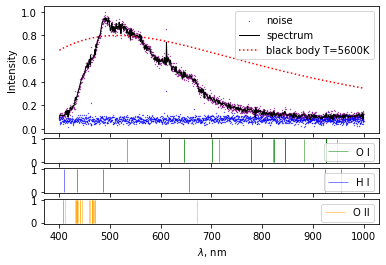

In [126]:
#show_spectrum( spectra['water'], 2.8, (350, 1000))

fig, (ax1,ax2,ax3,ax4) = plt.subplots(nrows=4, sharex=True, gridspec_kw={'height_ratios': [5, 1, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['water'], 0.6, (400, 1000), plot = ax1) 

no_lines = spectrum_lines("data/h2o_lines.txt")
#show_all_spectrum_lines( no_lines, (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('O I',), (400, 1000), plot = ax2)
show_named_spectrum_lines( no_lines, ('H I',), (400, 1000), plot = ax3)
show_named_spectrum_lines( no_lines, ('O II',), (400, 1000), plot = ax4)
ax2.legend()
ax3.legend()
ax4.legend()

show_blackbody( 5600, (400, 1000), 0.8, plot = ax1)

ax1.legend()

ax1.set_ylabel( r"Intensity")
ax4.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/water_lines.pdf')

### Lamp sharovaya Xe

1013
1805
5
24
AHTUNG!


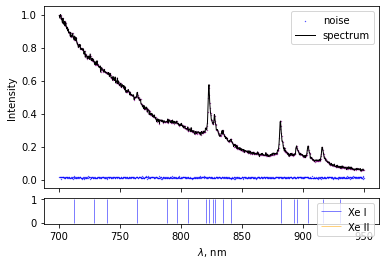

In [130]:
fig, (ax1,ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios': [7, 1], 'hspace': 0.1})
show_spectrum( spectra['lamp_sharovaya'], 0, (700, 950), plot = ax1) 

xe_lines = spectrum_lines( "data/xe_lines.txt", 26)
show_all_spectrum_lines( xe_lines, (700, 950), plot = ax2)
#show_named_spectrum_lines( xe_lines, ('Xe I',), (700, 1000), plot = ax2)
#show_named_spectrum_lines( xe_lines, ('Xe II',), (700, 1000), plot = ax3)
ax2.legend()
#ax3.legend()


ax1.legend()
ax1.set_ylabel( r"Intensity")
ax2.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/xe_lines_spherical.pdf')


### Lamp tube Xe

0
1976
0
30
0
22


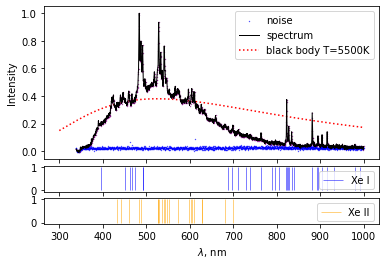

In [115]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [6, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['lamp_tube'], 0, (300, 1000), plot = ax1) 

xe_lines = spectrum_lines( "data/xe_lines.txt", 30)
#show_all_spectrum_lines( xe_lines, (300, 950), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Xe I',), (300, 1000), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Xe II',), (300, 1000), plot = ax3)
ax2.legend()
ax3.legend()

show_blackbody( 5500, (300, 1000), 0.38, plot = ax1)

ax1.legend()


ax1.set_ylabel( r"Intensity")
ax3.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/xe_lines.pdf')

### Tiratrone Xe

0
1976
0
30
0
22


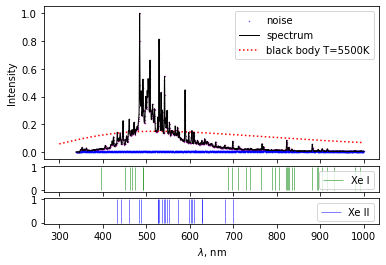

In [117]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [6, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['tirat_xe'], 0, (300, 1000), plot = ax1) 

xe_lines = spectrum_lines( "data/xe_lines.txt", 30)
#show_all_spectrum_lines( xe_lines, (300, 950), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Xe I',), (300, 1000), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Xe II',), (300, 1000), plot = ax3)
ax2.legend()
ax3.legend()

show_blackbody( 5500, (300, 1000), 0.15, plot = ax1)

ax1.legend()

ax1.set_ylabel( r"Intensity")
ax3.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/tirat_xe_lines.pdf')

### Lamp Ar

0
1976
0
40
0
45


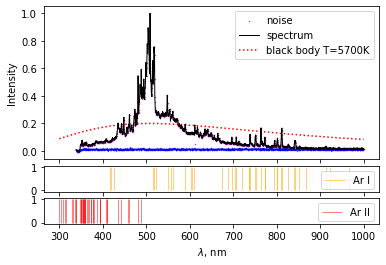

In [118]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios': [6, 1, 1], 'hspace': 0.1})
show_spectrum( spectra['lamp_ar'], 0, (300, 1000), plot = ax1) 

xe_lines = spectrum_lines( "data/ar_lines.txt", 45)
#show_all_spectrum_lines( xe_lines, (300, 950), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Ar I',), (300, 1000), plot = ax2)
show_named_spectrum_lines( xe_lines, ('Ar II',), (300, 1000), plot = ax3)
#show_named_spectrum_lines( xe_lines, ('Ar III',), (300, 1000), plot = ax3)
ax2.legend()
ax3.legend()

show_blackbody( 5700, (300, 1000), 0.20, plot = ax1)

ax1.legend()

ax1.set_ylabel( r"Intensity")
ax3.set_xlabel( r"$\lambda$, nm")

fig.savefig( 'gen/ar_lines.pdf')

## Energy

In [42]:
0.5/5

0.1

In [1]:
sensitivity = 5e-7 # Дж/дел. чувствительность калориметра №2

cal_trans = 0.14 # T Коэф пропускания на каллориметре
kdp_trans = 0.96 * 0.96 # Коэфф пропускания KDP
split_refl = 0.08 # Коэфф отражения разделителя (см. описание лабы)
prism_trans = 0.96 * 0.96 # То же, что и с KDP

value = 1610 # Условных единиц
energy = value * sensitivity / (cal_trans * kdp_trans * split_refl * prism_trans)
energy

print( "energy = {0:.3f} \pm {1:.3f}".format(energy, 0.10 * energy))

energy = 0.085 \pm 0.008


In [14]:
import math
pulse_time = 40e-9 # нс, время импульса
#diameter = 0.7e-1

wavelen = 1054e-9 # м, длина волны
photo_diameter = 4e-3 # м, диметр пятна на фотобумаге
focus = 18e-3 # м, фокусное расстояние линзы
#diameter = 10 * 1.22 * wavelen / photo_diameter * focus * 1e2 # см, диаметр пучка в фокусе
#diameter = 0.2e-1
# cm^2 !!!
divergence = 3e-3
diameter = divergence * focus * 1e2
S = lambda diam: math.pi * diam**2 / 4 
intensity = energy / (pulse_time * math.pi * diameter * diameter / 4)
intensity#*1e-11 # 10^5 МВт/см^2
print("{0:2e}".format(2 * intensity * 0.3))


5.542514e+10


In [7]:
diameter = divergence * focus
diameter * 0.3

1.6199999999999997e-05

In [ ]:
import math
pulse_time = 40e-9 # нс, время импульса
#diameter = 0.7e-1

wavelen = 1054e-9 # м, длина волны
photo_diameter = 4e-3 # м, диметр пятна на фотобумаге
focus = 18e-3 # м, фокусное расстояние линзы
#diameter = 10 * 1.22 * wavelen / photo_diameter * focus * 1e2 # см, диаметр пучка в фокусе
#diameter = 0.2e-1
# cm^2 !!!
divergence = 3e-3 + 1.22 * wavelen / photo_diameter
diameter = divergence * focus * 1e2
S = lambda diam: math.pi * diam**2 / 4 
intensity = energy / (pulse_time * math.pi * diameter * diameter / 4)
intensity#*1e-11 # 10^5 МВт/см^2
print("{0:2e}".format(2 * intensity))

In [66]:
3e-3 + 2 * 1.22 * wavelen / photo_diameter

0.00364294

In [60]:
diameter = 10 * 1.22 * wavelen / photo_diameter * focus #*1e2 # см, диаметр пучка в фокусе
diameter

5.7864599999999995e-05

In [28]:
6e9

6000000000.0

In [62]:
intensity * 0.2*1e-11

0.5920998574573074

In [54]:
(0.1**2 + 0.2**2 + 0.1**2)**(0.5)

0.24494897427831783

In [47]:
diameter = 5 * 1.22 * wavelen / photo_diameter * (100e-3)#focus
diameter

0.000160735

In [37]:

diameter * 1e-2

5.786459999999999e-06

In [11]:
(0.7e-1)**3

0.0003430000000000001

In [106]:
 wavelen / photo_diameter * 1e


0.2635

In [18]:
(photo_diameter / focus)**3

0.010973936899862828

In [ ]:
1.16e10 cm^2 / 7e11 cm^2